<a href="https://colab.research.google.com/github/PriyanshChaudhary/Transfer_learning_Dogs-Cats_CNN/blob/master/Dogs_Cats_Classifier_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tf-nightly-gpu
!pip install "tensorflow_hub==0.4.0"
!pip install -U tensorflow_datasets

     |████████████████████████████████| 376.9MB 37kB/s 
     |████████████████████████████████| 3.1MB 43.6MB/s 
     |████████████████████████████████| 61kB 27.5MB/s 
     |████████████████████████████████| 501kB 47.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
  Found existing installation: wrapt 1.10.11
    Uninstalling wrapt-1.10.11:
      Successfully uninstalled wrapt-1.10.11
     |████████████████████████████████| 686kB 4.7MB/s 


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tf.enable_eager_execution()

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [0]:
#using Tensorflow Hub Mobilenet v2 for prediction
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(URL, input_shape = (IMAGE_RES,IMAGE_RES,3))
])

65536/61306 [================================] - 0s 0us/step


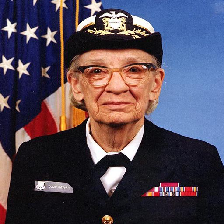

In [4]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES,IMAGE_RES))
grace_hopper

In [5]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [6]:
result = model.predict(grace_hopper[np.newaxis,...])
result.shape

(1, 1001)

In [7]:
predicted_class = np.argmax(result[0], axis = -1)
predicted_class


653

16384/10484 [==============================================] - 0s 0us/step


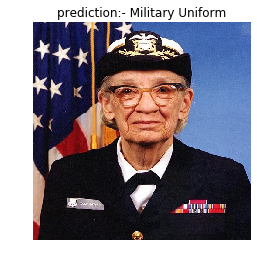

In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("prediction:- " + predicted_class_name.title())

In [9]:
splits = tfds.Split.ALL.subsplit(weighted = (80,20))
splits, info = tfds.load('cats_vs_dogs', with_info =True, as_supervised=True, split = splits)
(train_ex, val_ex)= splits
num_ex = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

W0607 05:14:23.798076 140365381257088 cats_vs_dogs.py:107] 1738 images were corrupted and were skipped


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


In [10]:
for i, example_image in enumerate(train_ex.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (500, 343, 3)
Image 2 shape: (375, 500, 3)
Image 3 shape: (375, 500, 3)


In [0]:
def format_image(image, label):
  image =tf.image.resize(image,(IMAGE_RES, IMAGE_RES))/255.0
  return image,label

BATCH_SIZE = 32

train_batches      = train_ex.shuffle(num_ex//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = val_ex.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [12]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Persian cat', 'bull mastiff', 'Egyptian cat', 'golden retriever',
       'English setter', 'Chihuahua', 'Egyptian cat', 'schipperke',
       'beagle', 'Egyptian cat', 'Egyptian cat', 'Egyptian cat',
       'Rhodesian ridgeback', 'Siberian husky', 'Egyptian cat',
       'Norfolk terrier', 'American Staffordshire terrier',
       'Egyptian cat', 'dingo', 'Labrador retriever', 'polecat',
       'Siamese cat', 'crossword puzzle', 'Egyptian cat', 'Egyptian cat',
       'Egyptian cat', 'vizsla', 'whippet', 'Egyptian cat',
       'Egyptian cat', 'miniature schnauzer', 'Labrador retriever'],
      dtype='<U30')

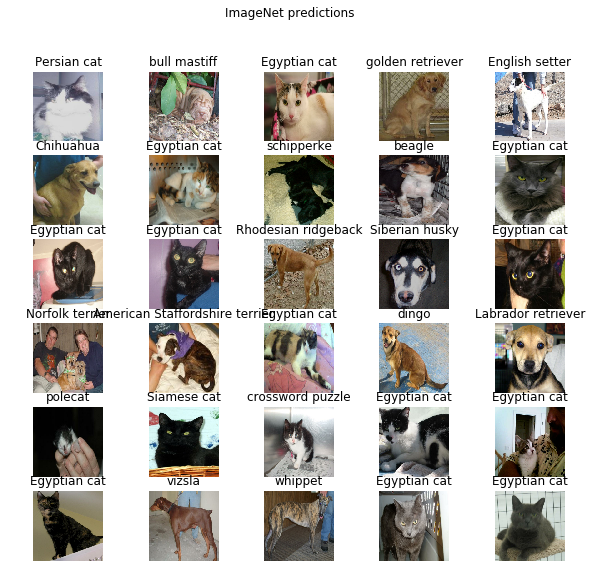

In [13]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [15]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor.trainable = False

In [17]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
model.compile(
  optimizer='adam', 
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 5
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 55s 94ms/step - loss: 0.2325 - acc: 0.9379 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/5
582/582 [==============================] - 48s 82ms/step - loss: 0.1879 - acc: 0.9592 - val_loss: 0.2110 - val_acc: 0.9500
Epoch 3/5
582/582 [==============================] - 48s 83ms/step - loss: 0.1796 - acc: 0.9631 - val_loss: 0.2108 - val_acc: 0.9506
Epoch 4/5
582/582 [==============================] - 48s 83ms/step - loss: 0.1744 - acc: 0.9659 - val_loss: 0.2120 - val_acc: 0.9502
Epoch 5/5
582/582 [==============================] - 47s 81ms/step - loss: 0.1706 - acc: 0.9678 - val_loss: 0.2130 - val_acc: 0.9515


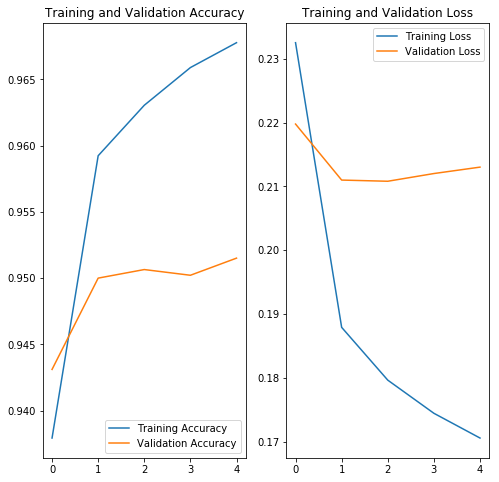

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [21]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog',
       'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat',
       'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog',
       'dog', 'cat', 'cat', 'dog', 'dog'], dtype='<U3')

In [22]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 1 0 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1]
Predicted labels:  [0 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1]


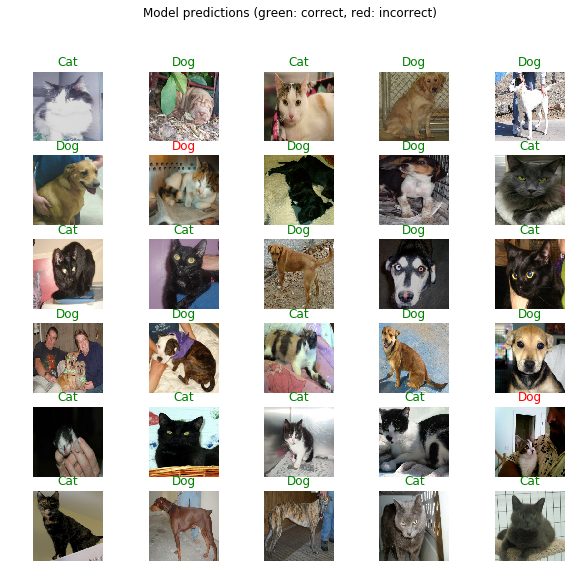

In [23]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")